In [3]:
library(reticulate)
library(sp)
library(sf)
library(gstat)
library(ggplot2)
library(repr)

In [4]:
np <- import("numpy", convert=FALSE)

In [5]:
path_tmp <- "../data/tmp"

* Read in atom positions saved in numpy arrays and convert them into 'simple feature' datasets

In [6]:
names <- c('re05', 're55', 're78', 're95') # hdf5 file name roots

In [7]:
atoms <- list()
for (nam in names) {
    pos <- as.matrix(np$load(file.path(path_tmp, paste0(nam, "_pos.npy"))))
    ids <- as.matrix(np$load(file.path(path_tmp, paste0(nam, "_ids.npy"))))
    atoms_mat <- cbind(pos, ids)
    atoms_df <- as.data.frame(cbind(pos, ids))
    names(atoms_df) <- c("x", "y", "id")
    coordinates(atoms_df) <- ~ x + y
    atoms[[nam]] <- st_as_sf(atoms_df)
}

In [8]:
options(repr.plot.width=4, repr.plot.height=3)

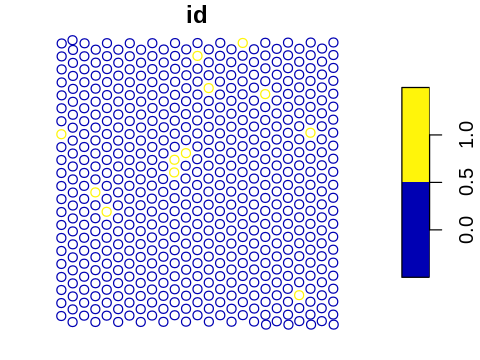

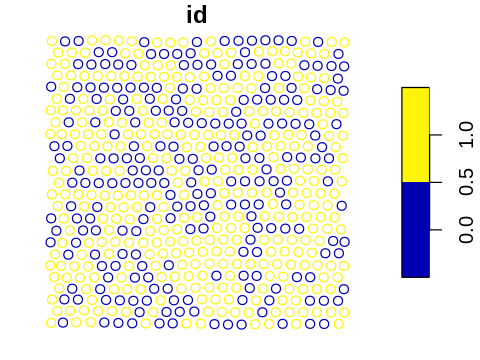

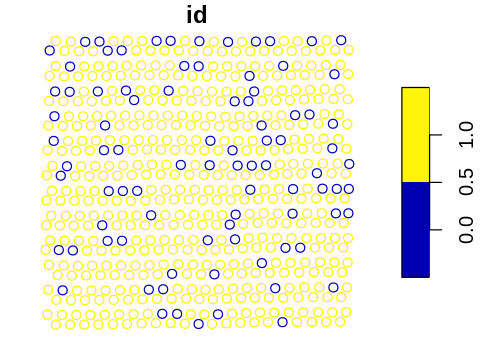

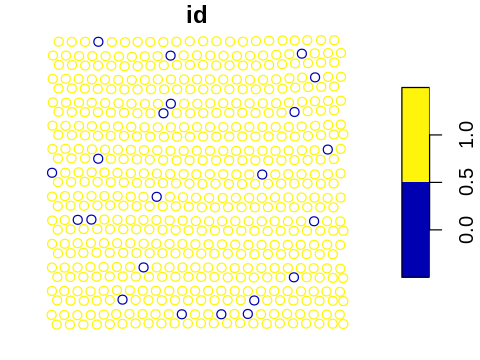

In [9]:
plot(atoms$re05)
plot(atoms$re55)
plot(atoms$re78)
plot(atoms$re95)

In [14]:
df <- data.frame(a = runif(50), b = rnorm(50), c = as.factor(sample(1:4, 50, replace = TRUE)))

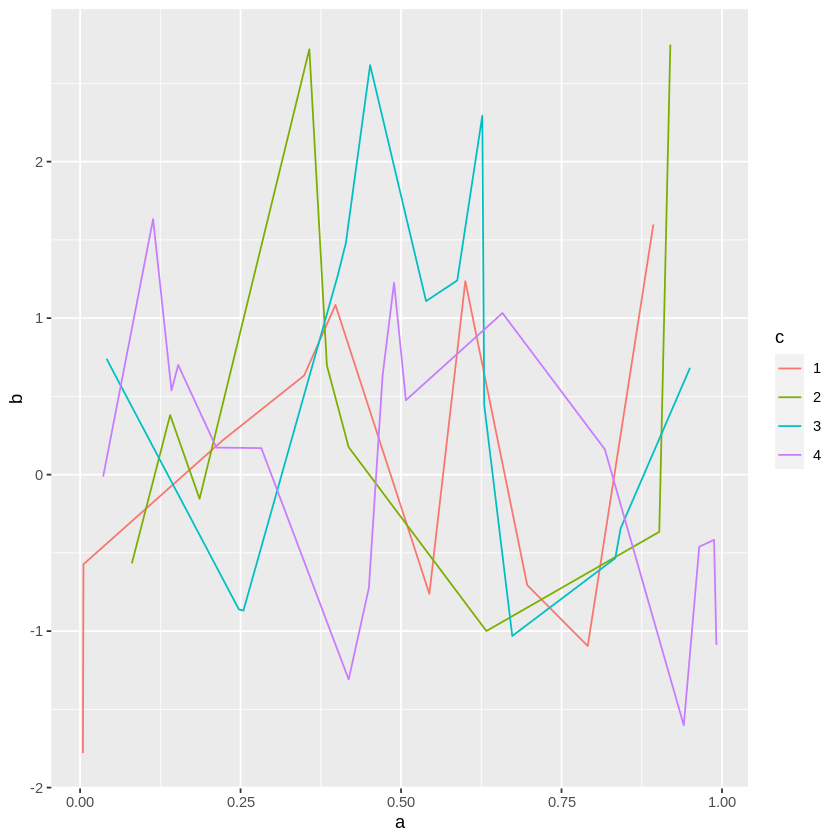

In [16]:
ggplot(df) + geom_line(aes(a, b, color = c))